>## Question 5. 
>The CSV “all_batters.csv” (see Google drive link below) contains a data set of seasonal stat lines: plate appearances, walks, strikeouts and home runs for a given player (player_id_hash). We are interested in identifying the 15 most valuable players for next season, assuming all players will have 400 plate appearances next season. Rank those players and quantify your level of confidence.  Your response should include:
A description of your methodology, model selection, and validation.
>
>Your submission should include (please attach in question #7):
>Any code used to perform this research
>Charts or tables that you would use to help communicate your findings.

## This question consists of two distinct problems: 
1. Forecasting - Using previous seasonal stat lines to predict future performances, and  
2. Ranking - Determining the appropriate weights of the given statistics, and how to combine them to form a rank.  

I deal with each of these stages seperate sections.

In [1]:
# Import Python Libraries that form backbone of analysis 
import pdb                      # debugger
import numpy as np              # numpy for scientific computing
import pandas as pd             # pandas for dataframes
import scipy as sp              # scipy for techincal computing
import matplotlib.pyplot as plt # matplotlib for plotting
   
%matplotlib inline

plt.style.use('ggplot')

# 1. Forecasting Future Performances

### Overview
Each player's previous performances are a indicative of their true talent $T$, such that each stat line $D$ is proportional to the likelihood $\mathcal{L}(D | T)$. Since we don't know $T$, but we do know that performances over time tend to \emph{regress to the mean}, we can additionally include a Prior $P(D)$, derived from the covariance of the entire ensemble of statistics, to estimate Posterior $P(T | D)$ --- i.e., a range of possible future performances.  Simple MCMC algorithms like $\texttt{emcee}$ are an efficient way to perform this type of analysis on a desktop or laptop. 

### Strategy
For any analysis, it is always instructive to begin with the simplest model to gain insights (and reality checks) before adding complexity.  With this in mind, and given the time constraint of the assignment, I will demonstrate the zero-th order analysis, and only outline further steps I would have taken. 

### Steps
1. Inspect, clean, and normalize data.  
2. Estimate covariance from normalized data.
3. Build model to estimate future performance.  

Read data into pandas dataframe

In [2]:
path_data = './'                 # define path to data
file_batters = 'all_batting.csv' # name of file
batters_data = pd.read_csv(path_data + file_batters) # read in data with pandas
print(""" Number of season stats = {0} """.format(len(batters_data)))
print(""" Number of unique batters = {0} """.format(len(np.unique(batters_data['player_id_hash'].values))))

 Number of season stats = 2102 
 Number of unique batters = 984 


Inspect contents of dataframe

In [3]:
batters_data.head() # Inspect contents of pandas dataframe

,player_id_hash,pa,bb,so,hr
0,65ded5353c5ee48d0b7d48c591b8f430,41,5,13,0
1,5878a7ab84fb43402106c575658472fa,174,4,40,5
2,9fc3d7152ba9336a670e36d0ed79bc43,247,21,75,2
3,7ef605fc8dba5425d6965fbd4c8fbe1f,10,1,4,0
4,38b3eff8baf56627478ec76a704e9b52,188,14,46,2


Inspect general data properties

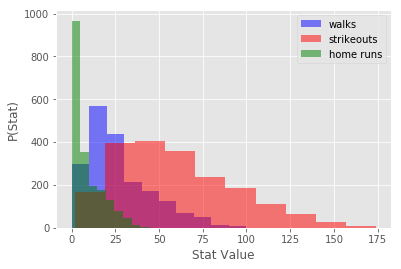

In [4]:
minpa = 50
n_bb, bins_bb, patches_bb = plt.hist(batters_data[batters_data.pa > minpa].bb, alpha = 0.5, color = 'blue',   label = 'walks')
n_so, bins_so, patches_so = plt.hist(batters_data[batters_data.pa > minpa].so, alpha = 0.5, color = 'red',   label = 'strikeouts')
n_hr, bins_hr, patches_hr = plt.hist(batters_data[batters_data.pa > minpa].hr, alpha = 0.5, color = 'green',   label = 'home runs')
plt.xlabel("Stat Value"); plt.ylabel("P(Stat)")
plt.legend()

Normalize by Plate Appearance (pa)

In [5]:
batters_data['norm_pa'] = batters_data.pa/np.mean(batters_data.pa)
batters_data['norm_bb'] = batters_data.bb.astype(float)/batters_data.pa.astype(float)
batters_data['norm_so'] = batters_data.so.astype(float)/batters_data.pa.astype(float)
batters_data['norm_hr'] = batters_data.hr.astype(float)/batters_data.pa.astype(float)
batters_data['mean_subtracted_npa'] = batters_data.norm_pa - np.mean(batters_data.norm_pa)
batters_data['mean_subtracted_nbb'] = batters_data.norm_bb - np.mean(batters_data.norm_bb)
batters_data['mean_subtracted_nso'] = batters_data.norm_so - np.mean(batters_data.norm_so)
batters_data['mean_subtracted_nhr'] = batters_data.norm_hr - np.mean(batters_data.norm_hr)

Inspect normalized data

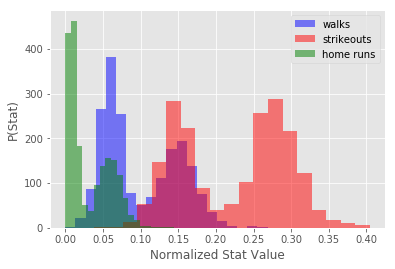

In [6]:
minpa = 50
n_nbb, bins_nbb, patches_nbb = plt.hist(batters_data[batters_data.pa > minpa].norm_bb, 'scott', alpha = 0.5, color = 'blue',   label = 'walks')
n_nso, bins_nso, patches_nso = plt.hist(batters_data[batters_data.pa > minpa].norm_so, 'scott', alpha = 0.5, color = 'red',   label = 'strikeouts')
n_nhr, bins_nhr, patches_nhr = plt.hist(batters_data[batters_data.pa > minpa].norm_hr, 'scott', alpha = 0.5, color = 'green',   label = 'home runs')
plt.xlabel("Normalized Stat Value"); plt.ylabel("P(Stat)")
plt.legend()

106


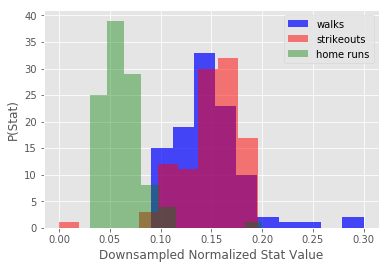

In [7]:
cut_nso = .2
cut_nbb = .09
cut_nhr = .03
ind_above_cuts = (batters_data['norm_hr'] > cut_nhr) & (batters_data['norm_bb'] > cut_nbb)  & (batters_data['norm_so'] < cut_nso) 

plt.hist(batters_data[ind_above_cuts].norm_bb, alpha = 0.7, color = 'blue',   label = 'walks')
plt.hist(batters_data[ind_above_cuts].norm_so, alpha = 0.5, color = 'red',     label = 'strikeouts')
plt.hist(batters_data[ind_above_cuts].norm_hr, alpha = 0.4, color = 'green',   label = 'home runs')
plt.xlabel("Downsampled Normalized Stat Value"); plt.ylabel("P(Stat)")

plt.legend()
print np.sum(ind_above_cuts)

Estimate the Covariance of the stats using the down-sampled data.  

In [8]:
minpa = 50
forcast_abs = 400 # Number of at-bats we are forecasting  
i_select = (batters_data['pa'] > minpa) & (ind_above_cuts == True) # index of selected batters
NORM_STATS_400 = forcast_abs * np.array([batters_data.norm_bb, batters_data.norm_hr, batters_data.norm_so])
COV_NORM_400 = np.cov(NORM_STATS_400[:,i_select], bias = True)
print(""" Number of selected season stats = {0} """.format(sum(i_select)))
print(""" Number of unique batters remaining = {0} """.format(len(np.unique(batters_data['player_id_hash'][i_select].values))))

 Number of selected season stats = 99 
 Number of unique batters remaining = 60 


In [9]:
league_ave_stats = np.mean(NORM_STATS_400[:,i_select],1)
league_err_stats = np.std(NORM_STATS_400[:,i_select],1)
print("""
    Selected Average Stats of select {0} players:
    BB = {1:.0f} +/- {2:.0f}
    HR = {3:.0f} +/- {4:.0f} 
    SO = {5:.0f} +/- {6:.0f} 
    for {7} at bats.
      """.format(len(np.unique(batters_data['player_id_hash'][i_select].values)),league_ave_stats[0], league_err_stats[0],league_ave_stats[1], league_err_stats[1],league_ave_stats[2], league_err_stats[2],400))


    Selected Average Stats of select 60 players:
    BB = 58 +/- 11
    HR = 24 +/- 7 
    SO = 60 +/- 10 
    for 400 at bats.
      


### Define forecasting function

In [10]:
def log_prior(player_true_talent, league_true_talent, cov):
    return -0.5 * sum( np.log(2 * np.pi * np.diag(cov))
                   + (league_true_talent - player_true_talent) ** 2 / np.diag(cov) )

def log_likelihood(player_true_talent, single_season_stats, cov):
    return - 0.5 * sum( np.log(2 * np.pi * np.diag(cov)) 
                   + np.log((single_season_stats - player_true_talent) ** 2  / np.diag(cov)) )

def log_posterior(player_true_talent, single_season_stats, league_true_talent, cov):
    if any((t < 0) | (t > 150) for t in player_true_talent):
        return -np.inf
    else:    
        return log_likelihood(player_true_talent, single_season_stats, cov)

### Define Variables

In [11]:
select_batters_single_season_stats, league_true_talent, cov = NORM_STATS_400[:,i_select], league_ave_stats, COV_NORM_400

Set up emcee

In [13]:
import emcee

ndim = 3  # number of parameters in the model
nwalkers = 150  # number of MCMC walkers
nburn = 100  # "burn-in" period to let chains stabilize
nsteps = 300  # number of MCMC steps to take
batters = np.unique(batters_data['player_id_hash'][i_select].values) # number of unique batters
nbatters = len(batters) # number of unique batters
posterior= {}

Set up simulation to loop over each batter.  
When a batter appears more than one season, those are combined in the prediction.  
No weights for at-bats are currently included. 

In [14]:
N = nbatters
for isim in range(N):

    single_season_stats = select_batters_single_season_stats[:,isim]
    # we'll start at random locations 
    starting_guesses =  league_true_talent  * ( 1 + 0.01 * league_true_talent * np.random.rand(nwalkers, ndim) )

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[single_season_stats, league_true_talent, cov])
    sampler.run_mcmc(starting_guesses, nsteps)

    sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
    sample = sampler.chain[:, nburn:, :] # discard burn-in points
    
    if batters[isim] in posterior:
        posterior[batters[isim]] += sample
        posterior[batters[isim]]  = posterior[batters[isim]]  / 2.
    else:
        posterior[batters[isim]] = sample

In [15]:
N = nbatters
forecasts_400abs = np.zeros([N,6])
for isim in range(N):
    forecasts_400abs[isim,0:2] = np.mean(posterior[batters[isim]][:,-1,0]), np.std(posterior[batters[isim]][:,-1,0])
    forecasts_400abs[isim,2:4] = np.mean(posterior[batters[isim]][:,-1,1]), np.std(posterior[batters[isim]][:,-1,1])
    forecasts_400abs[isim,4:6] = np.mean(posterior[batters[isim]][:,-1,2]), np.std(posterior[batters[isim]][:,-1,2])

In [16]:
forecasts_df = pd.DataFrame(forecasts_400abs)
#forecasts_df.rows    = batters[:5]
forecasts_df.columns = ['bb', 'sig_bb', 'hr', 'sig_hr', 'so', 'sig_so']

In [17]:
forecasts_df.head()

,bb,sig_bb,hr,sig_hr,so,sig_so
0,46.851770,18.895034,24.901192,28.155912,50.634407,24.554014
1,48.239333,21.639393,21.526095,25.182053,60.202486,19.586377
2,55.665958,20.224244,20.562210,23.518667,59.271129,16.221324
3,51.109075,21.466437,39.482531,14.836860,74.480454,22.320969
4,64.566994,16.217110,30.399084,16.624535,75.642316,16.965112


Plot Posteriors for randomly selected batter. 

/Users/marcoviero/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'P(Stat)')

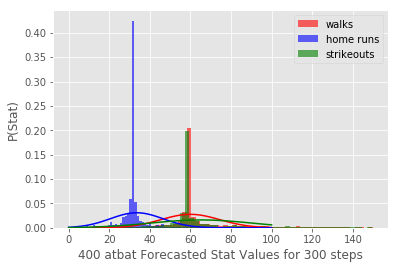

In [18]:
# plot a histogram of the sample
import random

random_batter = random.choice(batters)
sample_plot = posterior[random_batter]

hstyle = 'doane'
hstyle = 'scott'
n_bb, bins_bb, patches_bb = plt.hist(sample_plot[:,:,0].ravel(), hstyle, alpha=0.6, color = 'red', label = 'walks', normed = True)
n_hr, bins_hr, patches_hr = plt.hist(sample_plot[:,:,1].ravel(), hstyle, alpha=0.6, color = 'blue', label = 'home runs', normed = True)
n_so, bins_so, patches_so = plt.hist(sample_plot[:,:,2].ravel(), hstyle, alpha=0.6, color = 'green', label = 'strikeouts', normed = True)

plt.legend()

#plot a best-fit Gaussian
from scipy import stats
bb_fit = np.linspace(0, 100)
pdf_bb = stats.norm(np.mean(sample_plot[:,-1,0]), np.std(sample_plot[:,-1,0])).pdf(bb_fit)
plt.plot(bb_fit, pdf_bb, '-', color = 'red')

hr_fit = np.linspace(0, 100)
pdf_hr = stats.norm(np.mean(sample_plot[:,-1,1]), np.std(sample_plot[:,-1,1])).pdf(hr_fit)
plt.plot(hr_fit, pdf_hr, '-k', color = 'blue')

so_fit = np.linspace(0, 100)
pdf_so = stats.norm(np.mean(sample_plot[:,-1,2]), np.std(sample_plot[:,-1,2])).pdf(so_fit)
plt.plot(so_fit, pdf_so, '-k', color = 'green')
#plt.xlabel("BB"); plt.ylabel("P(BB)")
plt.xlabel("400 atbat Forecasted Stat Values for {0} steps".format(nsteps)); plt.ylabel("P(Stat)")

# 2. Ranking Predicted Peformances

### Overview
The relative weighting is complicated by the fact that the parameters are correlated (i.e., more home runs tends to also mean more strikeouts).

Some strategies to overcome this could be to use the inverse of the covariance to remove the correlations, also known as \emph{whitening}.
A more involved approach would be a full simulation, however, too much information is missing for that to be worthwhile.  

The values of the weights could also be treated as nuisance parameters be marginalized over.  That could be done with a Bayesian treatment, or easily brute-forced.  
Fortunately, the question of relative \emph{linear} weights has been investigated in depth, so we can draw upon that research here.  

### Strategy
1. Use simple linear weights and forecasts_df from previous step to rank players.  
2. Set up marginalization simulation to see how much potential variance there is.  

### Steps
1. Leverage literature to estimate linear weights.  
2. Build model to tabulate scores.  
3. Rank Players and Report

In [19]:
def weighted_score(forecasts, weights, top_X = 15):
    wscores = np.zeros(len(forecasts))
    for isc in range(len(wscores)):
        wscores[isc] = (weights[0] * forecasts[isc,0] + weights[1] * forecasts[isc,1] + weights[2] * forecasts[isc,2]) / sum(weights)
    
    rank = np.argsort(wscores)[::-1]

    return rank, wscores

### We use linear weights taken from the literature, in this case http://spiff.rit.edu/richmond/baseball/lwts/lwts_intro.html, though they are all roughly similar

In [24]:
forecasted_means = np.array(forecasts_df[['bb','hr','so']])
forecasted_error = np.array(forecasts_df[['sig_bb','sig_hr','sig_so']])
weights = np.array([0.32, 1.40, -0.29]) # Weights from http://spiff.rit.edu/richmond/baseball/lwts/lwts_intro.html
rnk, scr = weighted_score(forecasted_means, weights)

Final Rankings tabulated in pandas dataframe.  

In [26]:
final_ranking = pd.DataFrame(forecasts_df.values[rnk[:15]])
final_ranking.columns = ['bb', 'sig_bb', 'hr', 'sig_hr', 'so', 'sig_so']
final_ranking['score'] = scr[rnk[:15]]
final_ranking['batter_id'] = batters[rnk[:15]]
final_ranking

,bb,sig_bb,hr,sig_hr,so,sig_so,score,batter_id
0,57.501830,16.109066,46.261257,18.180788,66.261942,16.123413,44.720547,d1ee59e20ad01cedc15f5118a7626099
1,63.213058,17.119654,42.362389,16.562724,57.477838,17.878066,43.962903,970af30e481057c48f87e101b61e6994
2,67.609810,17.738130,41.500506,17.315589,66.035184,19.587512,42.367584,99adff456950dd9629a5260c4de21858
3,54.304749,20.252898,41.181210,17.712392,66.083884,18.884317,39.067753,41a60377ba920919939d83326ebee5a1
4,74.961497,15.549486,35.130924,20.713975,64.017197,15.650806,38.186003,42d6c7d61481d1c21bd1635f59edae05
5,69.935859,14.781030,35.509178,17.952413,62.305384,17.796518,37.778855,a760880003e7ddedfef56acb3b09697f
6,56.942270,14.485805,35.567596,15.644030,52.792199,25.828931,36.857639,9fc3d7152ba9336a670e36d0ed79bc43
7,72.751101,16.186189,31.557335,15.816158,54.205503,22.659056,36.182535,77f959f119f4fb2321e9ce801e2f5163
8,76.886234,18.595492,29.159208,19.109398,47.360299,17.853167,36.148252,81c8727c62e800be708dbf37c4695dff
9,68.342716,15.817132,31.305300,13.379092,52.853431,16.853756,35.223493,489d0396e6826eb0c1e611d82ca8b215


Brute force marginalization in this case would be to explore the parameter space with nested loops and compile scores.  
If I have time I will do that.  